In [61]:
import pmdarima as pm
from pmdarima import model_selection
from pmdarima.arima import auto_arima

import pandas as pd 
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import itertools

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#000000'

In [3]:
arima_series  = pd.read_csv('../datasets/data.csv', index_col=['date'], parse_dates=['date'], header=0)

In [6]:
arima_series.columns

Index(['work', 'income'], dtype='object')

Text(0.5, 0, 'Date')

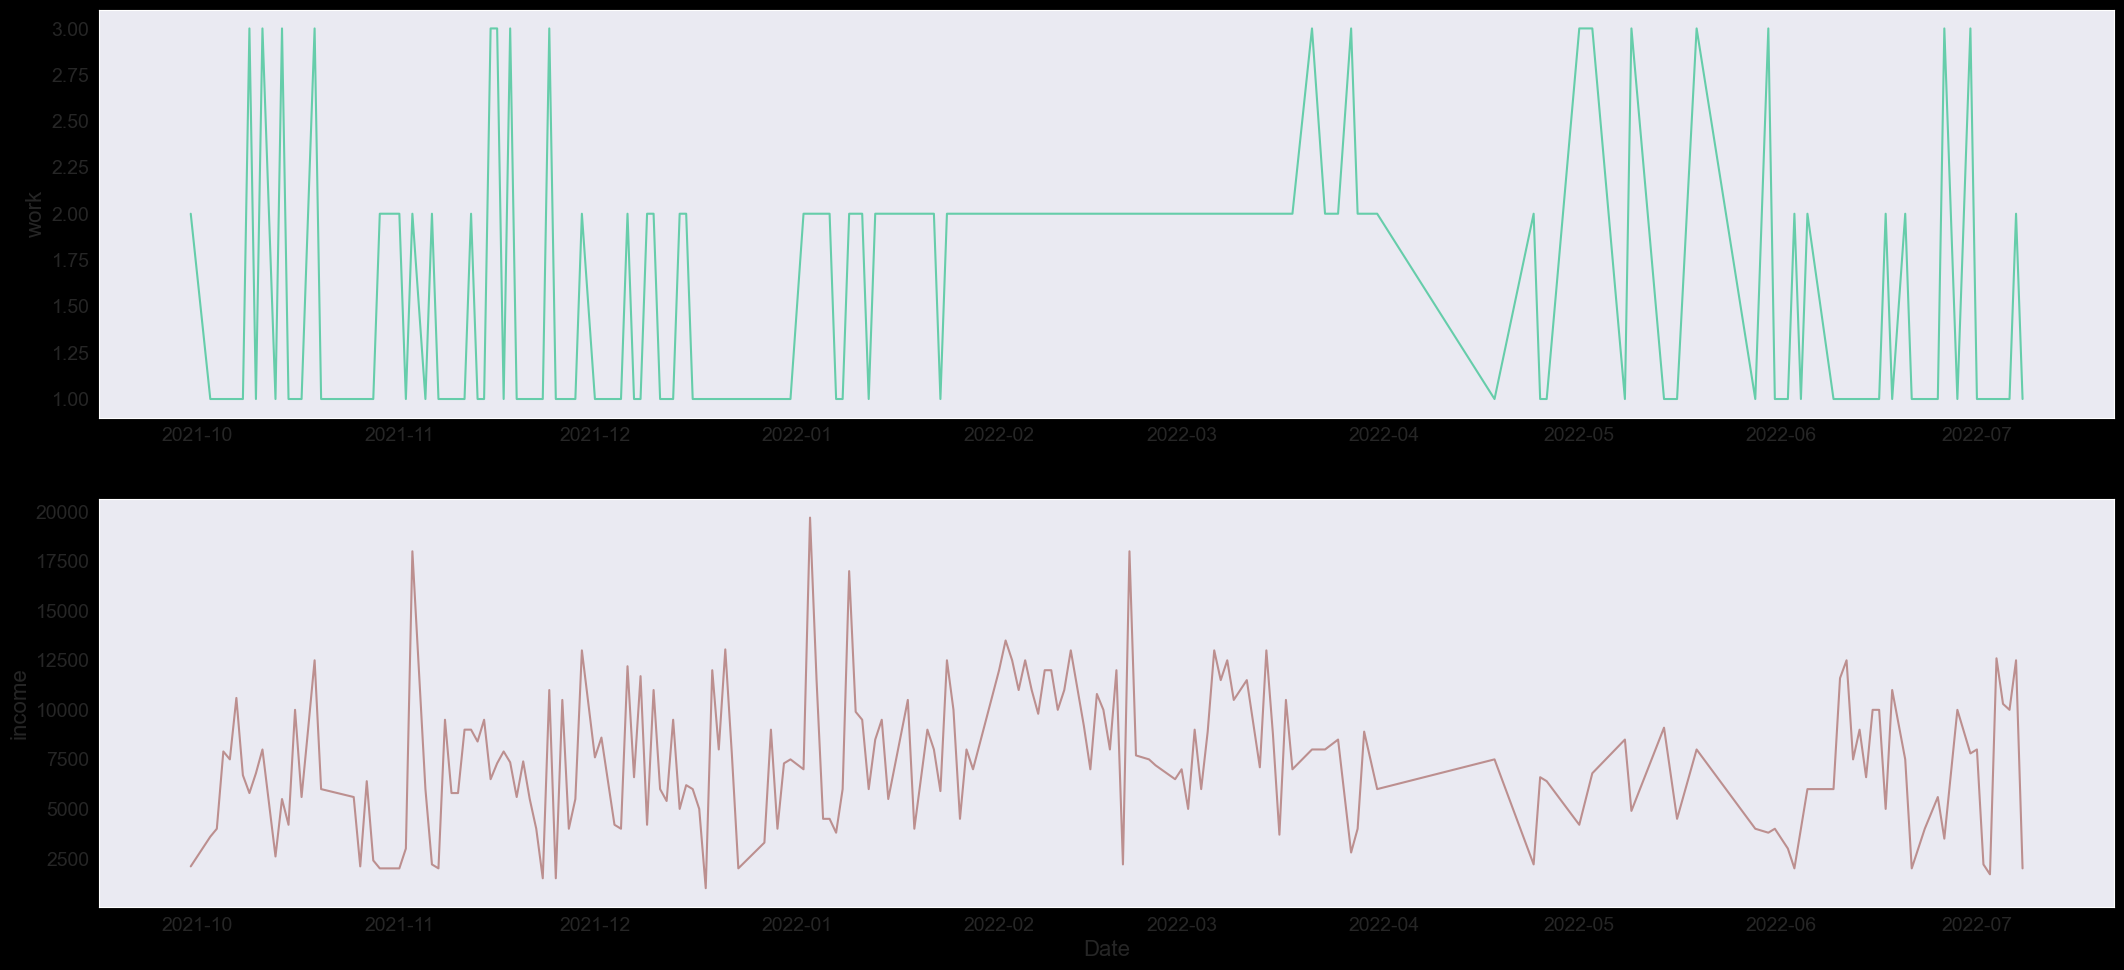

In [8]:
plt.figure(figsize=(26, 18))
colors = ['#66CDAA', '#BC8F8F']
for i, j in enumerate(arima_series.columns):
  plt.subplot(len(arima_series.columns) + 1, 1, i + 1)
  plt.plot(arima_series[j], color=colors[i]);
  plt.ylabel(j, fontsize=16)
  plt.grid()
plt.xlabel('Date', fontsize=16)

Text(0.5, 0, 'Date')

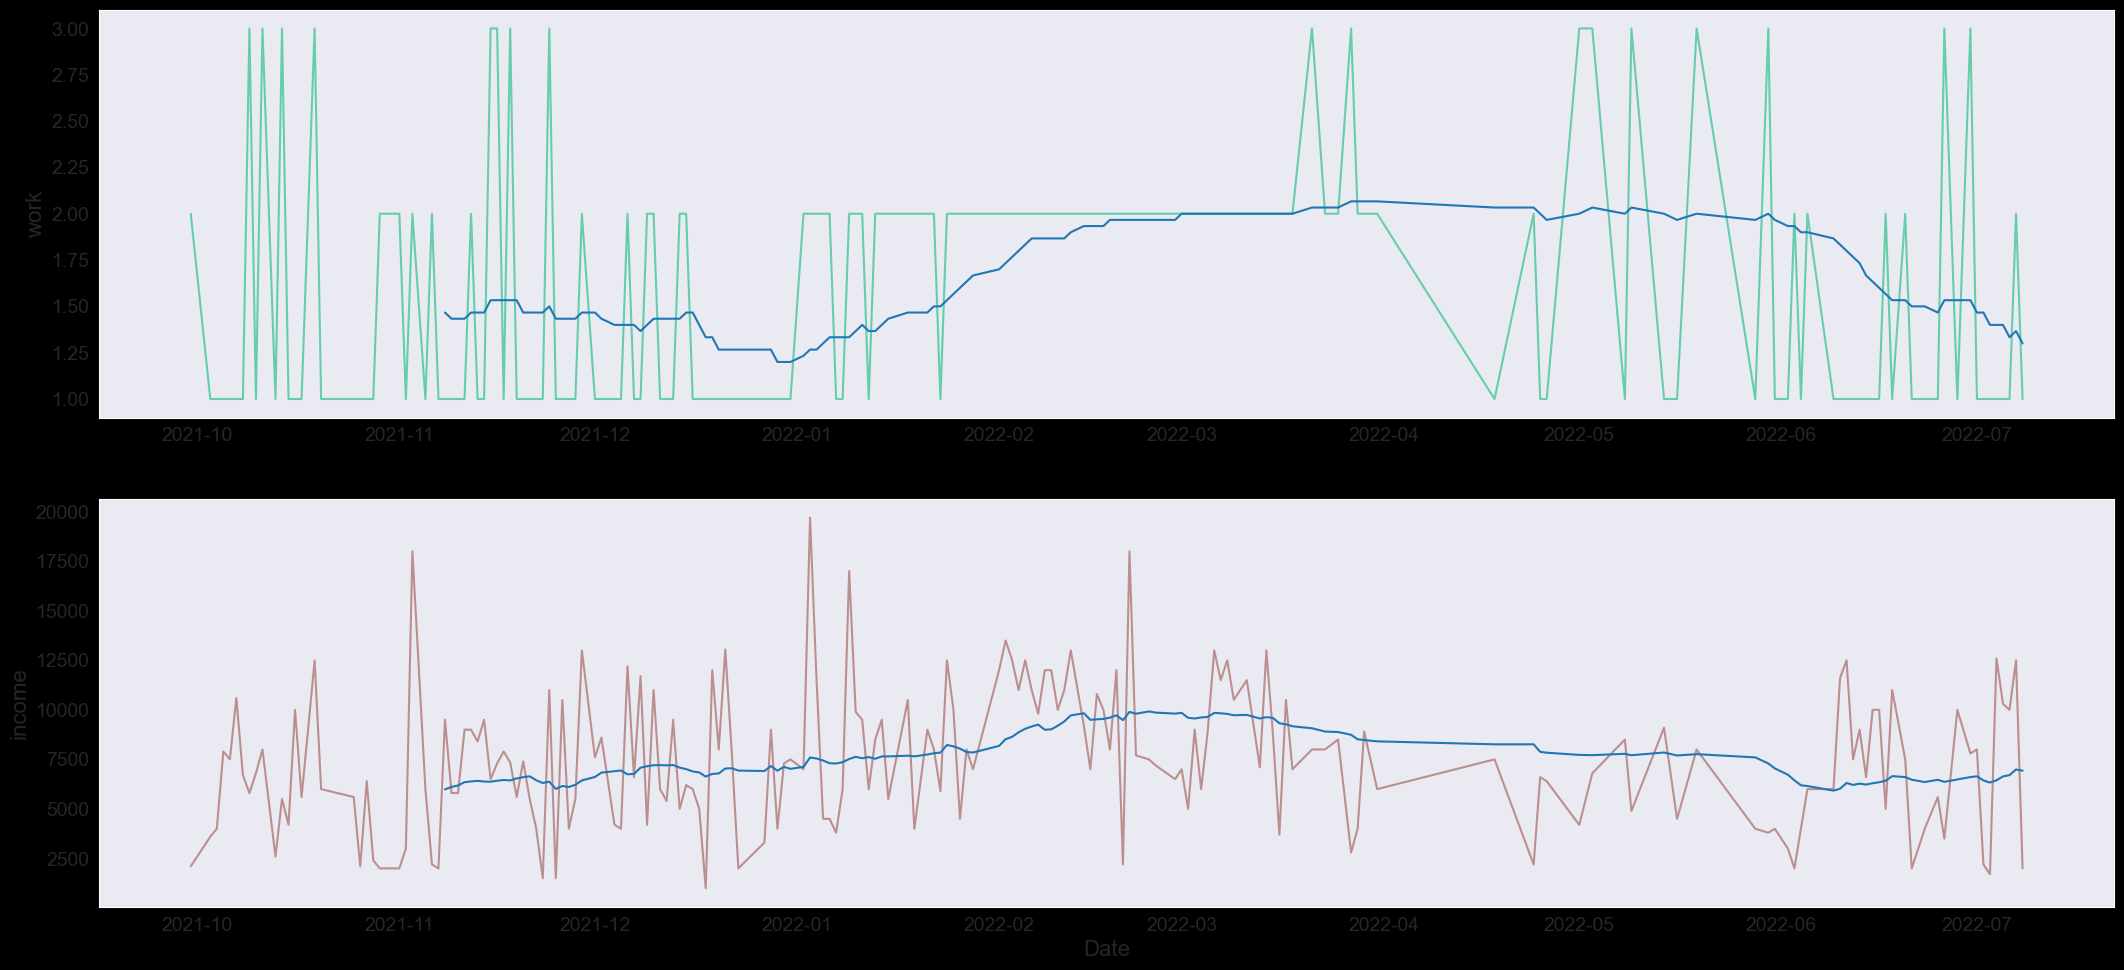

In [9]:
plt.figure(figsize=(26, 18))
colors = ['#66CDAA', '#BC8F8F']
for i, j in enumerate(arima_series.columns):
  plt.subplot(len(arima_series.columns) + 1, 1, i + 1)
  plt.plot(arima_series[j], color=colors[i]);
  plt.plot(arima_series[j].rolling(30).mean());
  plt.ylabel(j, fontsize=16)
  plt.grid()
plt.xlabel('Date', fontsize=16)

In [11]:
stationary_timeseries = []
for column in arima_series.columns:
  adf_test = adfuller(arima_series[column])
  if adf_test[1] < 0.05:
   stationary_timeseries.append(column)
  print(f'p-value for {column} is {adf_test[1]}')
if len(stationary_timeseries) == 0: 
  print('Check for stationarity')
else:
  print(f'Stationary time series: {stationary_timeseries}')

p-value for work is 0.008582909241893501
p-value for income is 8.597439226893762e-05
Stationary time series: ['work', 'income']


In [14]:
ts_decomposition = seasonal_decompose(x=arima_series['income'], model='additive', period=60)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

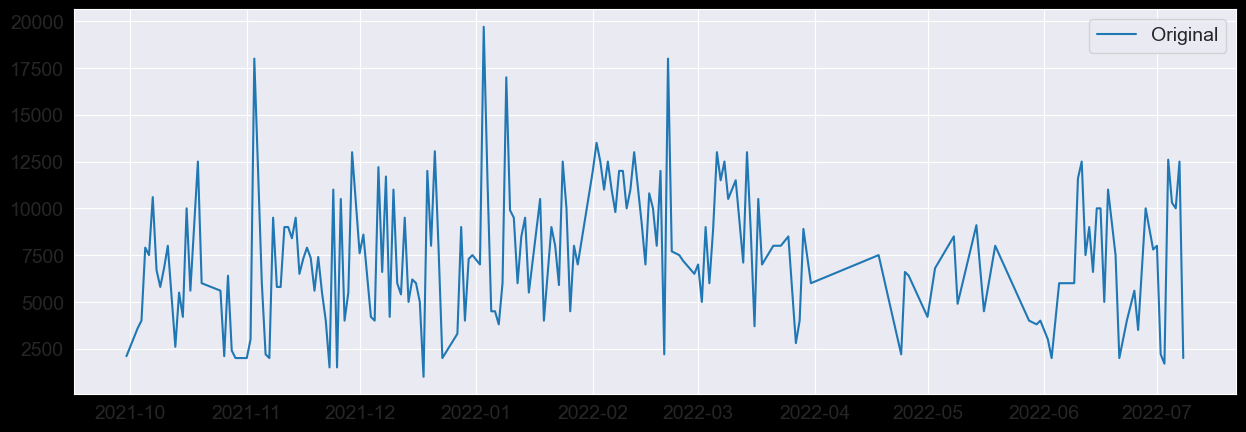

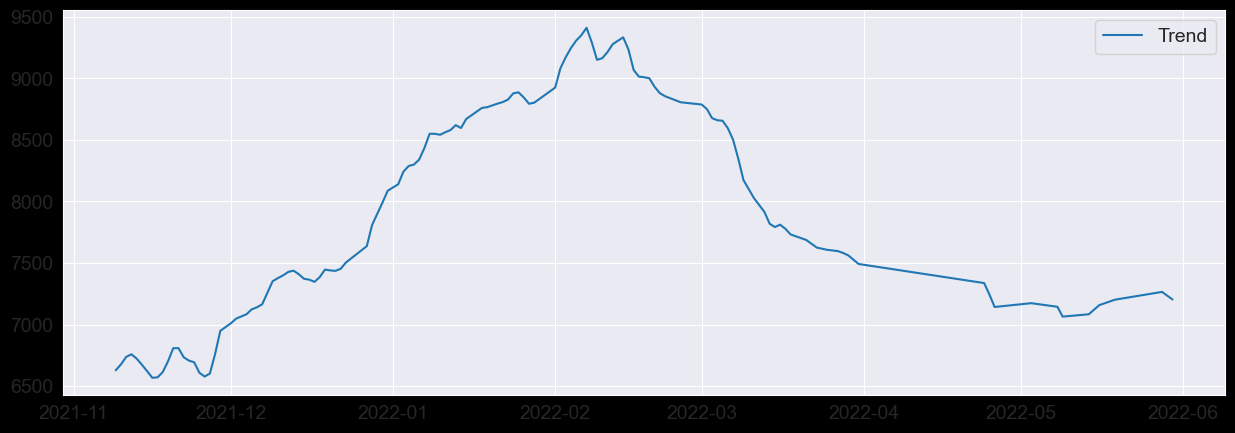

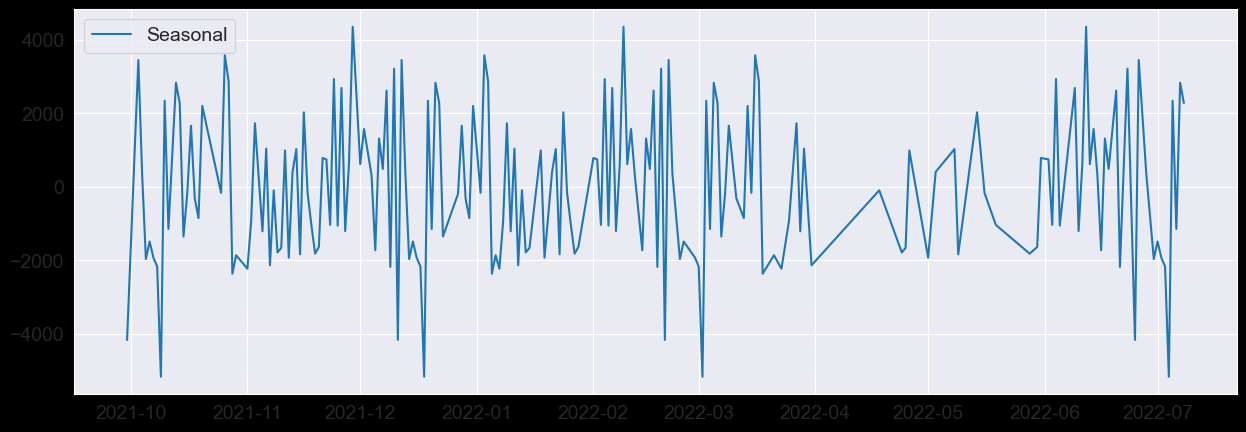

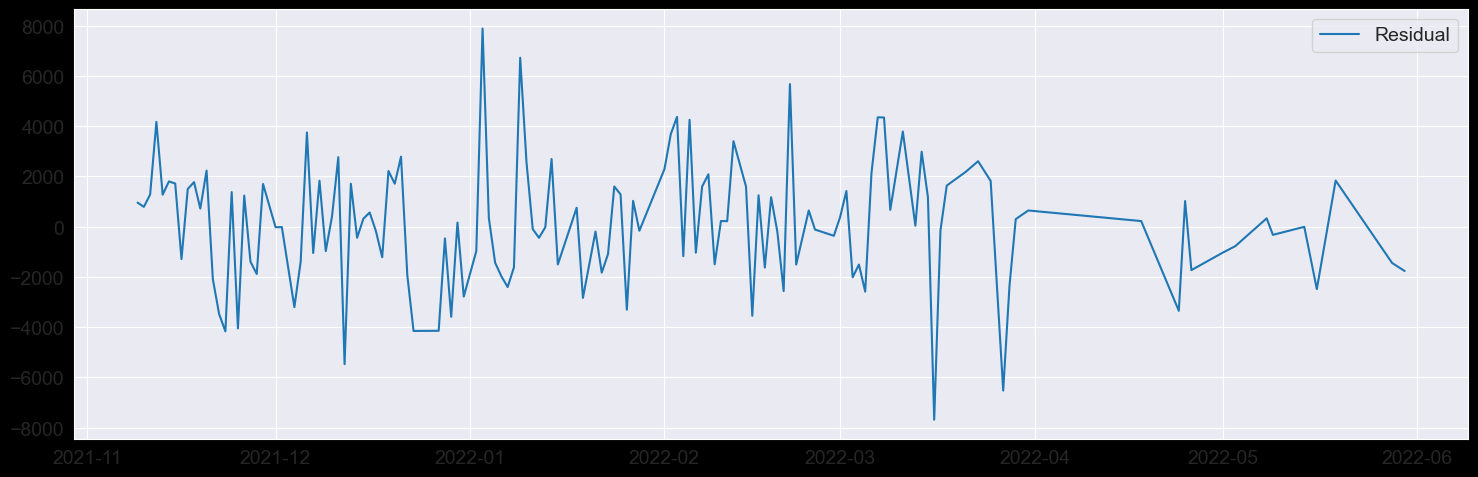

In [21]:
plt.figure(figsize=(15,5))
plt.plot(arima_series['income'], label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

In [17]:

print(f'p-value for decompose (residual) data is {adfuller(residual_estimate.dropna(axis=0))[1]}')

p-value for decompose (residual) data is 8.978660824209453e-20


P-value for log data 0.00012706394098555682


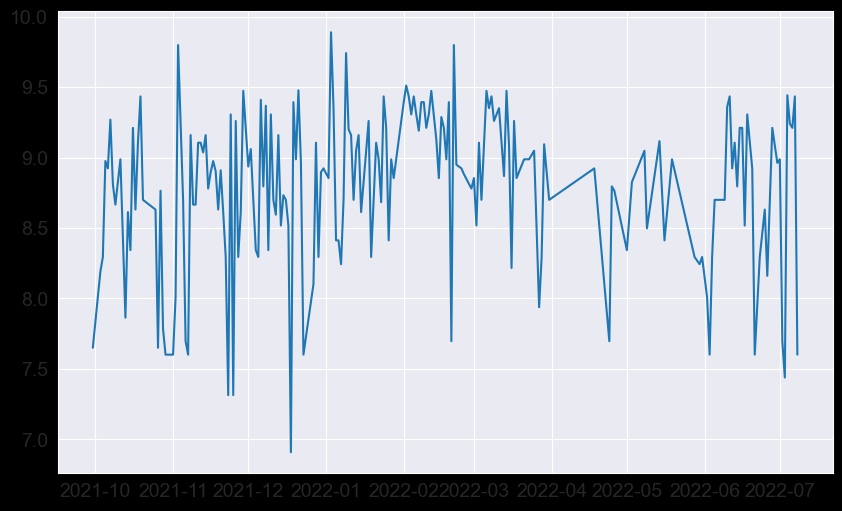

In [18]:
#taking the logarithms make the series homoskedastic - uniform central tendencies
statictic_log = adfuller(np.log1p(arima_series['income']))
print(f'P-value for log data {statictic_log[1]}')

log_data = np.log1p(arima_series['income'])
plt.plot(log_data)

P-value for diff data 7.673117529010934e-13


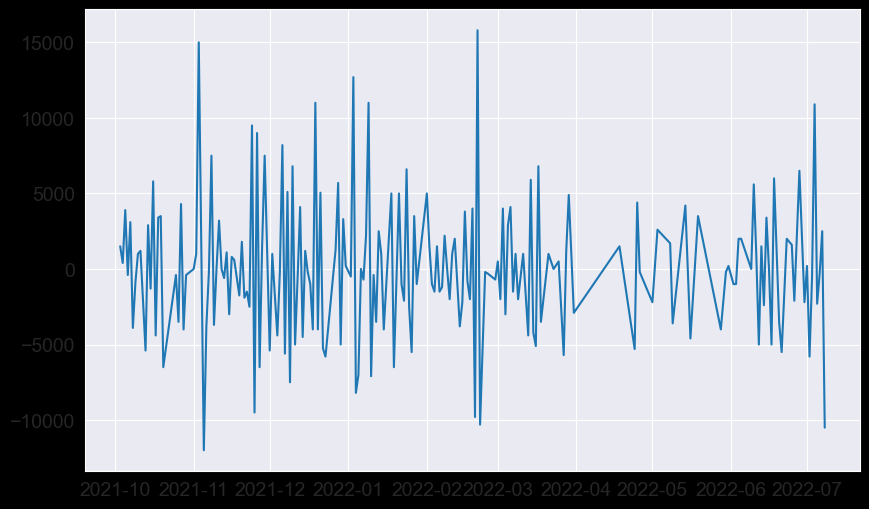

In [19]:
statictic_diff = adfuller(arima_series['income'].diff().dropna())
print(f'P-value for diff data {statictic_diff[1]}')
diff_data = arima_series['income'].diff().dropna()

plt.plot(diff_data)

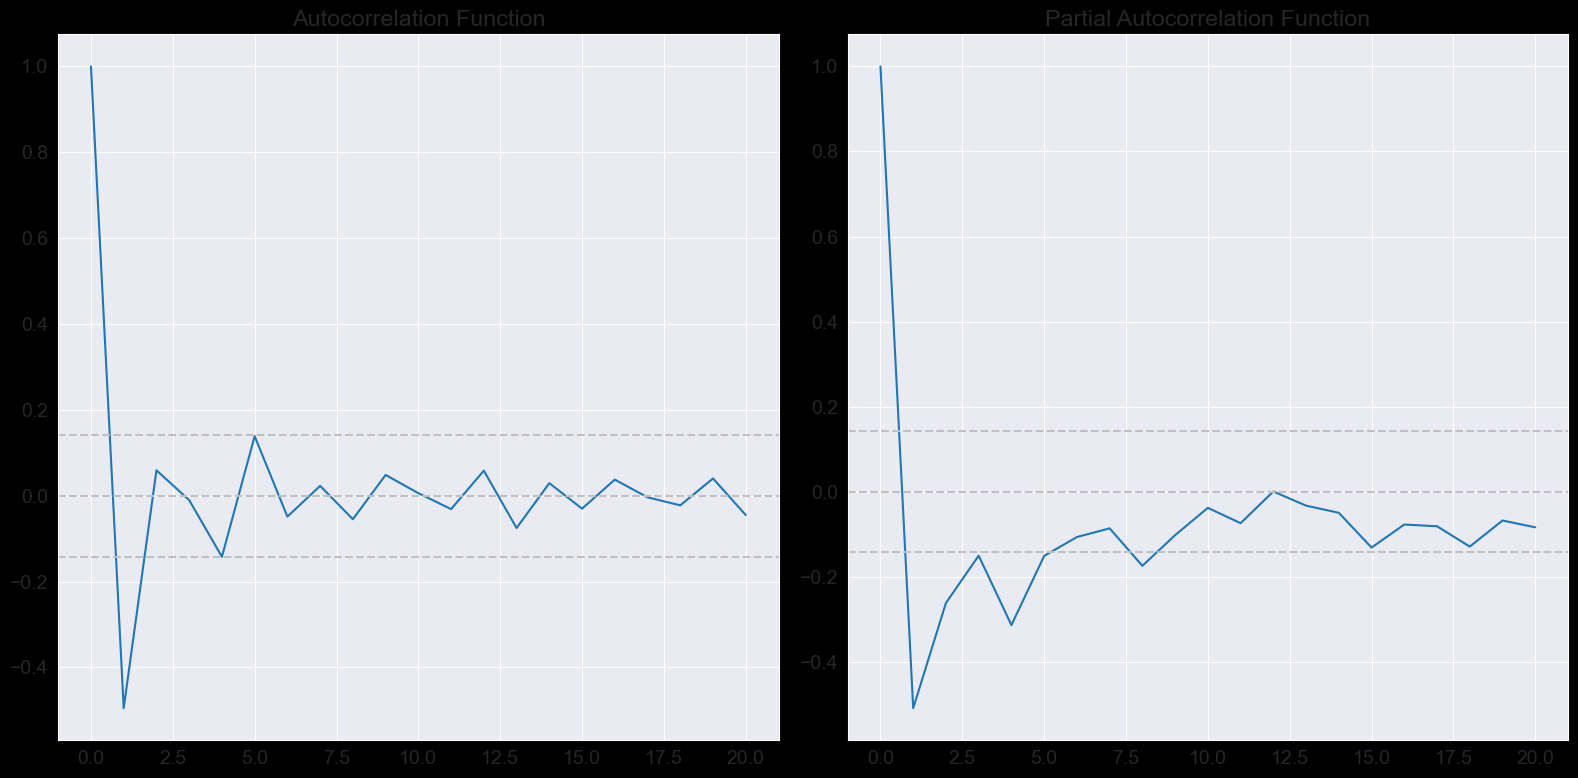

In [20]:
#determining the values for p and q
acf_lag = acf(diff_data.values, nlags=20)
pacf_lag = pacf(diff_data.values, nlags=20, method='ols')

plt.figure(figsize=(16,8))

plt.subplot(121)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(diff_data.values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(diff_data.values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(122)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(diff_data.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(diff_data.diff().values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

In [23]:
arima_series.columns

Index(['work', 'income'], dtype='object')

In [28]:
arima_series.shape

(192, 2)

In [33]:

train=arima_series[:-20]

In [34]:
arima = pm.auto_arima(arima_series['income'][:-20],
                      X=train.drop(columns=['income']),
                      error_action='ignore',
                      trace=True,
                      suppress_warnings=True,
                      maxiter=500,
                      m=4,
                      stationary=False,
                      test='adf'
                     )

print(arima.summary())
print(arima.params)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=2.97 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=3293.498, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=3297.110, Time=0.55 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=3339.464, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=3342.615, Time=0.08 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=3339.550, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=3339.623, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=3300.898, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=3339.018, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=3332.786, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=3289.764, Time=0.44 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : AIC=3289.461, Time=0.61 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=3342.717, Time=0.23 sec
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=3342.325, Time=0.28 sec
 ARIMA(1,0,1)(0,0,1)[4] intercept   : 

In [57]:
X = arima_series
size = int(len(X) * 0.64)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [58]:
test.shape

(70, 2)

c:\Users\Sheasier Shisia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


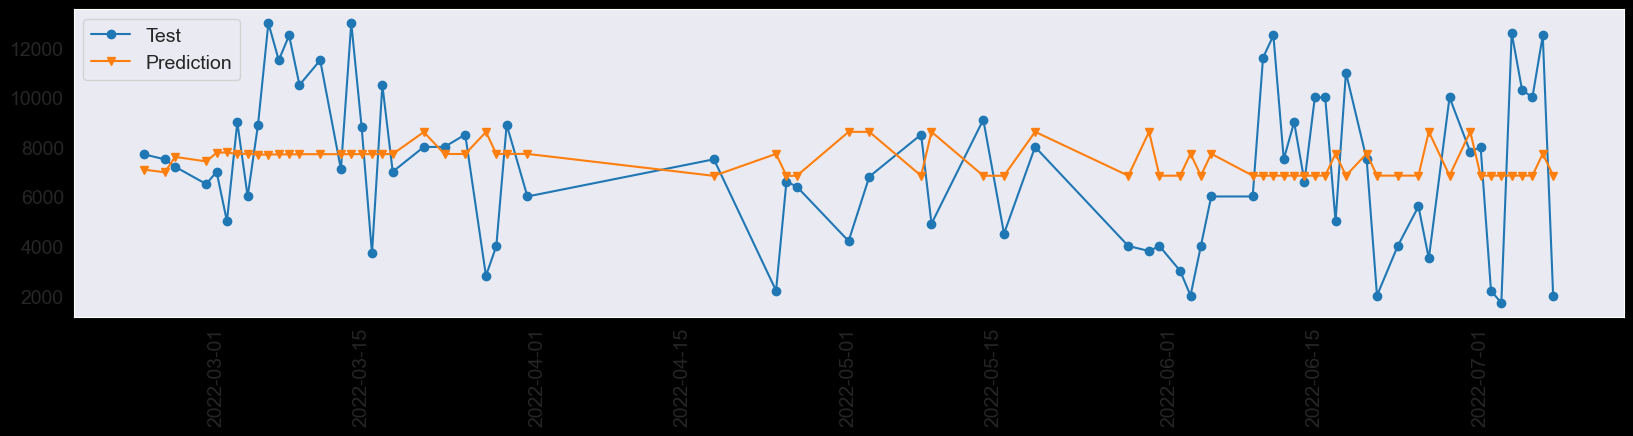

Mean Absolute Percentage Error 0.571525333172883
Mean Squared Error 10224736.5100427
RMSE 3197.6141903054377
AIC values 3289.4607064972183


In [66]:
pred = arima.predict(n_periods=70, 
                   X=test.drop(columns=['income']), 
                   alpha=0.05)

plt.figure(figsize=(20,4))
plt.grid()
ax = test.index
plt.plot(ax,test['income'], marker='o', label='Test')
plt.plot(ax,pred, marker='v', label='Prediction')
plt.legend()
plt.xticks(rotation=90)
plt.show()

print("="*50)
print("="*50)

MAE=mean_absolute_percentage_error(test['income'], pred)
print("Mean Absolute Percentage Error", MAE)
print("="*50)

MSE=mean_squared_error(test['income'], pred)
print("Mean Squared Error",MSE)
print("="*50)

print("RMSE", (MSE)**0.5)
print("="*50)
print("AIC values {}".format(arima.aic()))

In [68]:
predictions_df =pd.DataFrame(test['income'])

res=pd.DataFrame()
res['Test']=predictions_df['income']
res['Prediction']=pred.values
res['Difference']=res['Test']-res['Prediction']
res['% Change']=abs(res['Difference']/res['Test'])*100
res.head(20)

,Test,Prediction,Difference,% Change
date,,,,
2022-02-22,7700,7084.263199,615.736801,7.996582
2022-02-24,7500,6975.989883,524.010117,6.986802
2022-02-25,7200,7597.609027,-397.609027,5.522348
2022-02-28,6500,7414.768000,-914.768000,14.073354
2022-03-01,7000,7764.148393,-764.148393,10.916406
2022-03-02,5000,7780.022874,-2780.022874,55.600457
2022-03-03,9000,7705.447758,1294.552242,14.383914
2022-03-04,6000,7730.289263,-1730.289263,28.838154
2022-03-05,8900,7689.154769,1210.845231,13.605003


auto-arima score: RMSE 3197.6141903054377 : Train == 64%,   pdq == 101

best arima score: RMSE: 3187.563 :  Train == 64%,           pdq == 511

     Train size |   pdq |     Score   | Rank
##### 0.66      311 ==> Test RMSE: 3226.437  =4
##### 0.68      411 ==> Test RMSE: 3237.796  =5
##### 0.66      511 ==> Test RMSE: 3221.934  =3
##### 0.64      511 ==> Test RMSE: 3187.563  =1
##### 0.62      511 ==> Test RMSE: 3402.709  =6
##### 0.65      511 ==> Test RMSE: 3198.165  =2

### auto-arima score: RMSE 3197.6141903054377 : Train == 64%,   pdq == 101 =2